In [ ]:
# %cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_21_gs_color_compete_RawColor
%cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_05_07_split_l1_l2
!pwd

/home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_05_07_split_l1_l2
/bin/bash: /home/skyworker/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_05_07_split_l1_l2


In [2]:
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from model import *
from dataset import *
from renderer import render_batch, render_single

# Load YAML.
cfg = OmegaConf.load('config.yaml')
cfg.attention.num_slots = 10

# Get CFG
seed = cfg.training.seed
batch_size = cfg.training.batch_size
num_slots = cfg.attention.num_slots
num_iters = cfg.attention.num_iters
resolution = tuple(cfg.dataset.resolution)

# Set target frame.
frame = 5

# Load val dataset.
val_dir = '/home/skyworker/result/4DGS_SlotAttention/shape_of_motion/'
val_seq = 'movi_a_0000_anoMask'
test_set = ShapeOfMotion(os.path.join(val_dir,val_seq), cfg.dataset)

# Load model.
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
model = SlotAttentionAutoEncoder(cfg.dataset, cfg.cnn, cfg.attention).to(device)
ckpt = torch.load(os.path.join('checkpoints','best.ckpt'))
model.load_state_dict(ckpt['model_state_dict'])
print('Best epoch: ', ckpt['epoch'])

# Inference.
model = model.to(device)
sample = test_set[frame]
image = sample['gt_imgs'].to(device)
image = image.squeeze(0)[...,:3]
image = image.cpu().detach().numpy()

selected = [t for t in sample['gs']]
gs = torch.cat(selected, dim=-1)

Ks = sample['Ks']
w2cs = sample['w2cs']
gs = gs[None].to(device)
Ks = Ks[None].to(device)
w2cs = w2cs[None].to(device)
pe = sample['gs'][0][None].to(device)

ano = sample['ano']

renderer = Renderer(resolution, requires_grad=False)
gs_out, gs_slot, gs_mask, loss = model(gs,pe)

os.makedirs('render', exist_ok=True)

Best epoch:  200


In [4]:
from matplotlib import animation
from IPython.display import HTML
cmap_recon, _ = render_single(renderer, gs, gs_slot, gs_mask, Ks, w2cs, render_vid=True, color_code=True)
cmap_recon = cmap_recon.cpu().detach().numpy()
# cmap_slot = cmap_slot.cpu().detach().numpy()

vid = cmap_recon

dpi = 72
fig = plt.figure(figsize=(resolution[0]/dpi,resolution[1]/dpi), dpi=dpi)
im = plt.imshow(vid[0], interpolation='none')

plt.axis('off')  # turn off axis ticks and lines
plt.grid(False)  # disable grid
plt.tight_layout(pad=0)  # remove padding

def update(frame):
    im.set_data(vid[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(vid), interval=100)  # 100ms/frame
ani.save(f'render/{val_seq}_Recon_PLT_anim.gif', writer='pillow', fps=10)

plt.close()  # Prevents duplicate plot
HTML(ani.to_jshtml())  # or ani.to_html5_video()


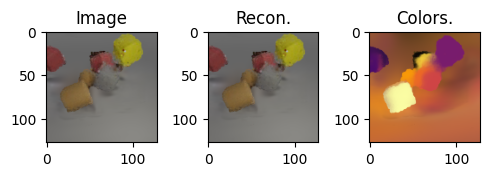

In [5]:
recon_combined, recon_slots = render_batch(renderer, gs, gs_slot, gs_mask, Ks, w2cs)
# Squeeze.
recon_combined = (recon_combined * 255).squeeze(0).to(torch.uint8)
recon_slots = (recon_slots * 255)
# recons = recons.squeeze(0)
# masks = masks.squeeze(0)

# Convert to numpy.
recon_combined = recon_combined.cpu().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(5, 2))
# plt.imshow(image, cmap='gray')
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
ax[2].imshow(vid[0])
ax[2].set_title('Colors.')
plt.tight_layout()

plt.savefig(f'render/{val_seq}_Recon_PLT.png')

# imageio.imwrite('render/0_image.png', (image*255).astype(np.uint8))
# imageio.imwrite('render/1_recon_combined.png', recon_combined)
# color_code = cv2.resize(color_code, (resolution[0], resolution[1]), interpolation=cv2.INTER_NEAREST)
# imageio.imwrite('render/2_color_code.png', color_code)

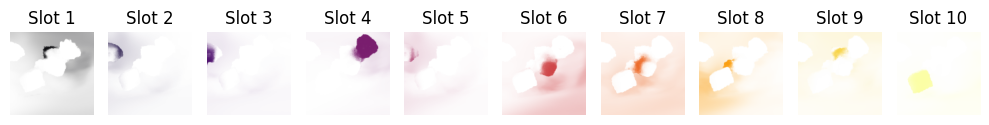

In [6]:
fig, ax = plt.subplots(1, num_slots, figsize=(10, 2))
stack = np.zeros((resolution[0], resolution[1], 4), dtype=np.uint8)
for i in range(num_slots):
  slot = recon_slots[i].squeeze(0).to(torch.uint8)
  picture = slot.cpu().detach().numpy()
  stack += picture
  # picture = recons[i] * masks[i] + (1 - masks[i])
  ax[i].imshow(picture)
  ax[i].set_title('Slot %s' % str(i + 1))
  # imageio.imwrite(f'render/3_slot_{i}.png', picture)
  # imageio.imwrite(f'render/3_slot_alpha_{i}.png', picture)
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')
# ax[num_slots].imshow(stack)
# ax[num_slots].set_title('Slot Stack')
plt.tight_layout()
plt.savefig(f'render/{val_seq}_Slot_{cfg.attention.num_slots}_PLT.png')

0.7088446803267773


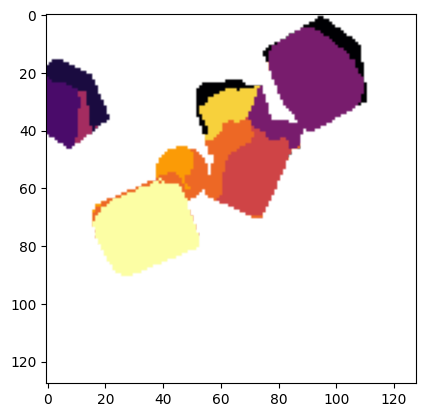

In [7]:
from sklearn.metrics import adjusted_rand_score
fg_mask = ano != 0
fg_mask = fg_mask.squeeze(-1)
slots = recon_slots[...,3].argmax(dim=0)
slots = slots.cpu().numpy()
plt.imshow(slots,cmap='inferno',alpha=fg_mask.astype(float))
slots = slots[fg_mask].flatten()
anos = ano[fg_mask].squeeze(-1).flatten()
arifg = adjusted_rand_score(anos,slots)
print(arifg)

In [8]:
# from gsplat.distributed import cli
# from simple_viewer import viewer
# from argparse import Namespace
# slot_num = 1
# out_slot = gs_slot[0][slot_num]
# out_slot = out_slot[:,:14]
# out_slot[:,10] = gs_slot[0,slot_num,:,14]
# args = Namespace(
#     port=8080,
#     gs = out_slot.detach().cpu()
# )

# viewer(args)

In [9]:
# !tensorboard --logdir=logs